In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance

In [2]:
start_date = '2016-02-01'
end_date = '2019-12-31'

In [3]:
data = yfinance.download("AUDUSD=X CADUSD=X CHFUSD=X \
                          CNYUSD=X DKKUSD=X EURUSD=X \
                          GBPUSD=X HKDUSD=X JPYUSD=X \
                          KZTUSD=X NOKUSD=X NZDUSD=X \
                          PLNUSD=X RUBUSD=X SEKUSD=X",
                        start=start_date, end=end_date)

[*********************100%***********************]  15 of 15 completed


In [4]:
data['Close'].head()

AUDUSD=X  CADUSD=X  CHFUSD=X  CNYUSD=X  DKKUSD=X  EURUSD=X  \
Date                                                                     
2016-02-01  0.706864  0.715676  0.976086  0.152297  0.145087  1.082591   
2016-02-02  0.711086  0.716846  0.980873  0.152244  0.146036  1.089728   
2016-02-03  0.702988  0.711238  0.981653  0.152212  0.146354  1.092204   
2016-02-04  0.715461  0.724942  0.994827  0.152277  0.148637  1.109102   
2016-02-05  0.719942  0.726998  1.006654  0.152560  0.150071  1.119996   

            GBPUSD=X  HKDUSD=X  JPYUSD=X  KZTUSD=X  NOKUSD=X  NZDUSD=X  \
Date                                                                     
2016-02-01  1.424603  0.128481  0.008241  0.002743  0.115135  0.646998   
2016-02-02  1.442793  0.128553  0.008275  0.002805  0.115201  0.654579   
2016-02-03  1.440922  0.128317  0.008343  0.002683  0.114683  0.652018   
2016-02-04  1.458576  0.128345  0.008466  0.002762  0.116773  0.664717   
2016-02-05  1.458109  0.128403  0.008557  0.002772  0.117701  0.672993   

            PLNUSD=X  RUBUSD=X  SEKUSD=X  
Date                                      
2016-02-01  0.245228  0.013256  0.116426  
2016-02-02  0.247986  0.012943  0.117306  
2016-02-03  0.248004  0.012545  0.116964  
2016-02-04  0.251062  0.012999  0.118491  
2016-02-05  0.253291  0.013026  0.119067

In [5]:
new_data = data['Close'].interpolate(method='polynomial', order=3)

In [6]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [7]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [8]:
values = new_data.values

In [9]:
values

array([[0.70686364, 0.71567619, 0.9760859 , ..., 0.24522787, 0.01325557,
        0.11642582],
       [0.71108586, 0.71684587, 0.98087299, ..., 0.24798575, 0.01294331,
        0.11730605],
       [0.70298767, 0.71123755, 0.98165292, ..., 0.24800359, 0.01254469,
        0.1169644 ],
       ...,
       [0.69247282, 0.76016724, 1.02103329, ..., 0.26049808, 0.01617817,
        0.10641468],
       [0.69463742, 0.7628929 , 1.01887989, ..., 0.26060671, 0.01608338,
        0.10633377],
       [0.69829965, 0.76491195, 1.02699983, ..., 0.26248854, 0.01611572,
        0.10722665]])

In [10]:
values.shape

(1018, 15)

In [11]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [12]:
scaled

array([[0.25593185, 0.0386939 , 0.0439291 , ..., 0.15635943, 0.1321969 ,
        0.5885236 ],
       [0.28590202, 0.04889107, 0.0861063 , ..., 0.19794154, 0.07479477,
        0.62116647],
       [0.2284193 , 0.        , 0.09297752, ..., 0.19821048, 0.00151777,
        0.6084964 ],
       ...,
       [0.15378284, 0.42654943, 0.43994617, ..., 0.38659692, 0.6694524 ,
        0.21726441],
       [0.16914749, 0.4503107 , 0.42097282, ..., 0.38823485, 0.65202737,
        0.21426368],
       [0.19514275, 0.46791172, 0.4925146 , ..., 0.41660833, 0.65797377,
        0.24737573]], dtype=float32)

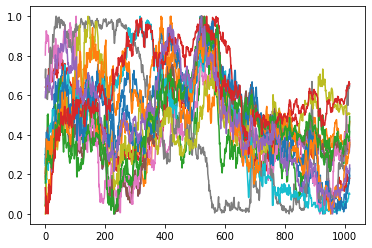

In [13]:
plt.plot(scaled)
plt.show()

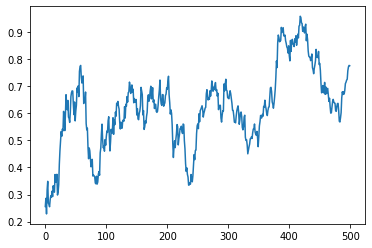

In [14]:
plt.plot(scaled[:,0][0:500])

In [15]:
# specify the number of lag hours
n_hours = 3
n_features = 15
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(1015, 60)


In [16]:
reframed.head()

var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.255932   0.038694   0.043929   0.641567   0.187778   0.205439   
4   0.285902   0.048891   0.086106   0.638932   0.221347   0.239113   
5   0.228419   0.000000   0.092978   0.637329   0.232592   0.250793   
6   0.316959   0.119473   0.209049   0.640536   0.313314   0.330521   
7   0.348768   0.137392   0.313253   0.654541   0.363995   0.381919   

   var7(t-3)  var8(t-3)  var9(t-3)  var10(t-3)  ...   var6(t)   var7(t)  \
3   0.803655   0.689125   0.000000    0.245129  ...  0.330521  0.926417   
4   0.869385   0.733315   0.019286    0.334864  ...  0.381919  0.924726   
5   0.862624   0.586983   0.057711    0.157589  ...  0.356006  0.899799   
6   0.926417   0.604622   0.127063    0.272308  ...  0.377130  0.872320   
7   0.924726   0.640358   0.178442    0.287877  ...  0.424396  0.883111   

    var8(t)   var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  var14(t)  \
3  0.604622  0.127063  0.272308  0.373074  0.314500  0.244324  0.085001   
4  0.640358  0.178442  0.287877  0.414318  0.379076  0.277930  0.089982   
5  0.626678  0.174965  0.268323  0.374189  0.301089  0.271344  0.075103   
6  0.595451  0.228566  0.346323  0.361250  0.292529  0.252371  0.024158   
7  0.579330  0.248814  0.342190  0.362554  0.310711  0.292359  0.005140   

   var15(t)  
3  0.665094  
4  0.686477  
5  0.653353  
6  0.660273  
7  0.678825  

[5 rows x 60 columns]

In [17]:
# split into train and test sets
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [18]:
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(500, 45) (500,)
(500, 3, 15) (500,) (515, 3, 15) (515,)


In [19]:
train_X[0]

array([[0.25593185, 0.0386939 , 0.0439291 , 0.64156723, 0.18777752,
        0.20543861, 0.8036547 , 0.68912506, 0.        , 0.24512935,
        0.30025148, 0.1762433 , 0.15635943, 0.1321969 , 0.5885236 ],
       [0.28590202, 0.04889107, 0.0861063 , 0.63893175, 0.22134686,
        0.23911333, 0.86938477, 0.7333145 , 0.01928616, 0.3348639 ,
        0.30319977, 0.23539543, 0.19794154, 0.07479477, 0.62116647],
       [0.2284193 , 0.        , 0.09297752, 0.6373286 , 0.23259163,
        0.25079298, 0.8626237 , 0.5869827 , 0.05771112, 0.15758896,
        0.28015852, 0.21541405, 0.19821048, 0.00151777, 0.6084964 ]],
      dtype=float32)

In [20]:
train_y[0]

0.3169589

In [21]:
values[:,0][0:4]

array([0.25593185, 0.28590202, 0.2284193 , 0.3169589 ], dtype=float32)

W0512 13:53:53.912560 21192 deprecation_wrapper.py:119] From D:\Мои документы\env\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0512 13:53:53.928517 21192 deprecation_wrapper.py:119] From D:\Мои документы\env\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0512 13:53:53.930512 21192 deprecation_wrapper.py:119] From D:\Мои документы\env\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0512 13:53:54.129010 21192 deprecation_wrapper.py:119] From D:\Мои документы\env\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0512 13:53:54.279605 21192 deprecation.py:323] From D:\Мои документы\env\lib\site-packages\tens

Train on 500 samples, validate on 515 samples
Epoch 1/50
 - 1s - loss: 0.4324 - val_loss: 0.1205
Epoch 2/50
 - 0s - loss: 0.1286 - val_loss: 0.2127
Epoch 3/50
 - 0s - loss: 0.1270 - val_loss: 0.2415
Epoch 4/50
 - 0s - loss: 0.1059 - val_loss: 0.1418
Epoch 5/50
 - 0s - loss: 0.0879 - val_loss: 0.1404
Epoch 6/50
 - 0s - loss: 0.0695 - val_loss: 0.1841
Epoch 7/50
 - 0s - loss: 0.0721 - val_loss: 0.1907
Epoch 8/50
 - 0s - loss: 0.0714 - val_loss: 0.1650
Epoch 9/50
 - 0s - loss: 0.0645 - val_loss: 0.1698
Epoch 10/50
 - 0s - loss: 0.0611 - val_loss: 0.1804
Epoch 11/50
 - 0s - loss: 0.0600 - val_loss: 0.1690
Epoch 12/50
 - 0s - loss: 0.0575 - val_loss: 0.1665
Epoch 13/50
 - 0s - loss: 0.0556 - val_loss: 0.1652
Epoch 14/50
 - 0s - loss: 0.0539 - val_loss: 0.1578
Epoch 15/50
 - 0s - loss: 0.0525 - val_loss: 0.1551
Epoch 16/50
 - 0s - loss: 0.0512 - val_loss: 0.1510
Epoch 17/50
 - 0s - loss: 0.0499 - val_loss: 0.1478
Epoch 18/50
 - 0s - loss: 0.0488 - val_loss: 0.1449
Epoch 19/50
 - 0s - loss: 0

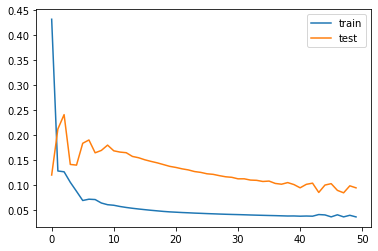

In [22]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [24]:
test_X.shape

(515, 45)

In [25]:
test_X[:, -14:].shape

(515, 14)

In [26]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -14:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -14:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.015


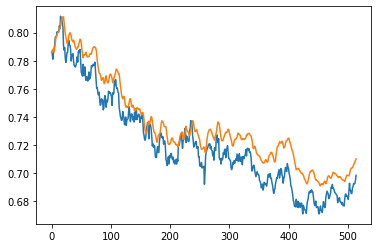

In [27]:
plt.plot(inv_y)
plt.plot(inv_yhat)

In [28]:
test_X[0]

array([0.7991471 , 0.7716198 , 0.51347256, 0.7251253 , 0.7874861 ,
       0.78931475, 0.5688386 , 0.3523407 , 0.37772465, 0.6573193 ,
       0.65672016, 0.66799545, 0.82897544, 0.89090514, 0.81732726,
       0.79522943, 0.74772644, 0.4607525 , 0.71447706, 0.76199293,
       0.7642956 , 0.5381708 , 0.34626007, 0.3614812 , 0.65226865,
       0.6668792 , 0.66017866, 0.8242943 , 0.9137695 , 0.8041556 ,
       0.8203559 , 0.7792115 , 0.48610783, 0.72594595, 0.78892565,
       0.7918558 , 0.5531907 , 0.3391571 , 0.3536439 , 0.67066646,
       0.6933799 , 0.7115259 , 0.84684443, 0.9220731 , 0.83119845],
      dtype=float32)

In [29]:
test_X[0][-14:]

array([0.7792115 , 0.48610783, 0.72594595, 0.78892565, 0.7918558 ,
       0.5531907 , 0.3391571 , 0.3536439 , 0.67066646, 0.6933799 ,
       0.7115259 , 0.84684443, 0.9220731 , 0.83119845], dtype=float32)

In [30]:
inv_y

array([0.78610176, 0.7848062 , 0.78106695, 0.7847322 , 0.7885813 ,
       0.79088897, 0.7962924 , 0.7971303 , 0.79725105, 0.80057645,
       0.80021125, 0.8008328 , 0.80044824, 0.80489373, 0.8029226 ,
       0.8116883 , 0.80959857, 0.8101102 , 0.8061266 , 0.8040524 ,
       0.79063886, 0.7874636 , 0.78939056, 0.78173864, 0.7787495 ,
       0.7820198 , 0.7859164 , 0.78610176, 0.7928328 , 0.79438215,
       0.7912019 , 0.79088897, 0.78809035, 0.7798426 , 0.783951  ,
       0.78384036, 0.78499097, 0.7793625 , 0.77657837, 0.7764699 ,
       0.7754703 , 0.776699  , 0.7786343 , 0.7827115 , 0.77905893,
       0.78626865, 0.78729004, 0.785799  , 0.7879786 , 0.7789376 ,
       0.77160496, 0.77083176, 0.7690533 , 0.77747804, 0.7693491 ,
       0.77086145, 0.7756147 , 0.7687577 , 0.76600766, 0.76858044,
       0.7683029 , 0.7654624 , 0.76820254, 0.7719981 , 0.76683   ,
       0.76822615, 0.7699593 , 0.7763975 , 0.7765181 , 0.77573496,
       0.77744776, 0.7772907 , 0.776699  , 0.778889  , 0.77233

In [31]:
concatenate((yhat, test_X[:, -14:]), axis=1)

array([[0.8136835 , 0.7792115 , 0.48610783, ..., 0.84684443, 0.9220731 ,
        0.83119845],
       [0.8269616 , 0.8338952 , 0.47998714, ..., 0.82978654, 0.9211278 ,
        0.82362294],
       [0.83250153, 0.82177067, 0.4586296 , ..., 0.78691506, 0.9153702 ,
        0.79150176],
       ...,
       [0.26507625, 0.42201853, 0.4316864 , ..., 0.3671515 , 0.6642511 ,
        0.21214747],
       [0.27306077, 0.42654943, 0.43994617, ..., 0.38659692, 0.6694524 ,
        0.21726441],
       [0.27827203, 0.4503107 , 0.42097282, ..., 0.38823485, 0.65202737,
        0.21426368]], dtype=float32)

In [32]:
concatenate((yhat, test_X[:, -14:]), axis=1).shape

(515, 15)

In [33]:
test_X[:, -14:].shape

(515, 14)

In [34]:
yhat

array([[0.8136835 ],
       [0.8269616 ],
       [0.83250153],
       [0.82028395],
       [0.81931   ],
       [0.8332965 ],
       [0.86164784],
       [0.88579464],
       [0.8981987 ],
       [0.9042188 ],
       [0.9142855 ],
       [0.9196884 ],
       [0.9237567 ],
       [0.9290616 ],
       [0.9439318 ],
       [0.95349985],
       [0.97621375],
       [0.98554134],
       [0.99572814],
       [0.9939185 ],
       [0.9969001 ],
       [0.9663793 ],
       [0.93032634],
       [0.9102829 ],
       [0.8955186 ],
       [0.87815857],
       [0.8633586 ],
       [0.8662885 ],
       [0.8800793 ],
       [0.8997686 ],
       [0.91328096],
       [0.9165941 ],
       [0.9118499 ],
       [0.9001055 ],
       [0.8813396 ],
       [0.87394476],
       [0.8703467 ],
       [0.8787631 ],
       [0.87063104],
       [0.85468876],
       [0.8431506 ],
       [0.83823144],
       [0.83243084],
       [0.8374578 ],
       [0.8454041 ],
       [0.8454449 ],
       [0.8610404 ],
       [0.873